In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
from scipy.optimize import least_squares

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z):
    k = 1+z
    c = 300000
    central_vel = c*z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    lower_bounds = [0,0,0,0,central_vel - 1000,0,0,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
    upper_bounds = [np.inf,np.inf,np.inf,np.inf,central_vel + 1000,200,np.inf,np.inf,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf]
    bounds_p_init = (lower_bounds,upper_bounds)
    try:
        res = least_squares(Type2_gauss_coupled,x0=p_init,bounds=bounds_p_init,args=(wo_wave[select],data[select],error[select]),max_nfev = 10000000)
        popt_full_fit = res['x']  
    except RuntimeError:
        popt_full_fit = [1e-5,1e-5,1e-5,1e-5,6562.8*k,1e-5,1e-5,1e-5,1e-5,1e-5,6562.8*k,1e-5,0.0001,0.01]
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        try:
            res_MC =least_squares(Type2_gauss_coupled,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),max_nfev = 10000000)
            popt_MC = res_MC['x'] 
        except RuntimeError:
            popt_MC = [1e-5,1e-5,1e-5,1e-5,6562.8*k,1e-5,1e-5,1e-5,1e-5,1e-5,6562.8*k,1e-5,0.0001,0.01]
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_Ha_fit,amp_NII6583_fit,amp_SII6716_fit,amp_SII6731_fit,vel_Ha_fit,vel_sigma_Ha_fit,amp_Ha_br_fit,amp_NII6583_br_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_Ha_br_fit,vel_sigma_Ha_br_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    new_k = 1+ (vel_Ha_fit/300000)
    select = (wo_wave>6400*new_k) & (wo_wave < 6800*new_k)
    
    select2 = (wo_wave>4750*new_k) & (wo_wave < 5090*new_k)
    select3 = (wo_wave>4990*new_k) & (wo_wave < 5017*new_k)
    
    SN = np.mean(data[select3]/error[select3])
    print (SN)
    fit = Type2_gauss_coupled(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+nlr_gauss_coupled(wo_wave[select],amp_Ha_fit,amp_NII6583_fit,amp_SII6716_fit,amp_SII6731_fit,vel_Ha_fit,vel_sigma_Ha_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+nlr_gauss_coupled(wo_wave[select],amp_Ha_br_fit,amp_NII6583_br_fit,amp_SII6716_br_fit,amp_SII6731_br_fit,vel_Ha_br_fit,vel_sigma_Ha_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    ax1.set_xlim(6400,6800)
    #ax1.set_ylim(0,0.5)
   # ax1.annotate(r'H$\beta$',xy=(4871.33,0.05),xytext=(4881.33,0.1),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
   # ax1.annotate(r'[OIII] 4959,5007',xy=(4959,0.2),xytext=(4929,0.3),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
   # ax1.annotate(r'',xy=(5000,0.2),xytext=(4975,0.3),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    #ax1.legend(fontsize=17)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left')

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='r', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.5, color='darkgray')
    ax2.set_xlim(6400,6800)
    #ax2.set_ylim(-8,8)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/Spectrum/%s_central_eline_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)


    fig2 = plt.figure(figsize=(10, 10)) 
    #gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    #ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
    ax1 = fig2.add_axes([0.12, 0.10, 0.84, 0.84]) # inset axes
    #plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    
    ax1.plot(wo_wave[select2]/new_k,data[select2],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.set_xlim(4750,5090)
    #ax1.set_ylim(0,0.5)
   # ax1.annotate(r'H$\beta$',xy=(4871.33,0.05),xytext=(4881.33,0.1),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
   # ax1.annotate(r'[OIII] 4959,5007',xy=(4959,0.2),xytext=(4929,0.3),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
   # ax1.annotate(r'',xy=(5000,0.2),xytext=(4975,0.3),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    ax1.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left')
    fig2.savefig('%s/Spectrum/%s_central_OIII_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)

    

In [5]:
def algorithm_script(obj,p_init,z,destination_path_cube="/media/rickeythecat/Seagate/3C264/MUSE"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadMainCube('%s/%s.wo_absorption.fits'%(destination_path_cube,obj)) 
    wo_cube[np.isnan(wo_cube)] = 0.0000001
    wo_err[np.isnan(wo_err)] = 0.000001
    (brightest_pixel_y,brightest_pixel_x) = ndimage.measurements.maximum_position(wo_cube[1584,:,:])
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    error = factor*error
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit)

3C264


No handles with labels found to put in legend.


[ 805.91608506  893.75196848  190.68814282  166.3384272  6511.84236577
  102.91469849  133.79018855  649.33612332   88.17172147  152.09766283
 6501.49709675  340.90373569  -11.68408699   79.81769103] [179.91516859  80.36387319  34.5609983   71.88989071   3.65430571
  61.44610187 176.35828477  76.65128118  30.20223632  40.10820034
   6.92345272  61.02231437  18.24539612 123.76898425]
2.4748526


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


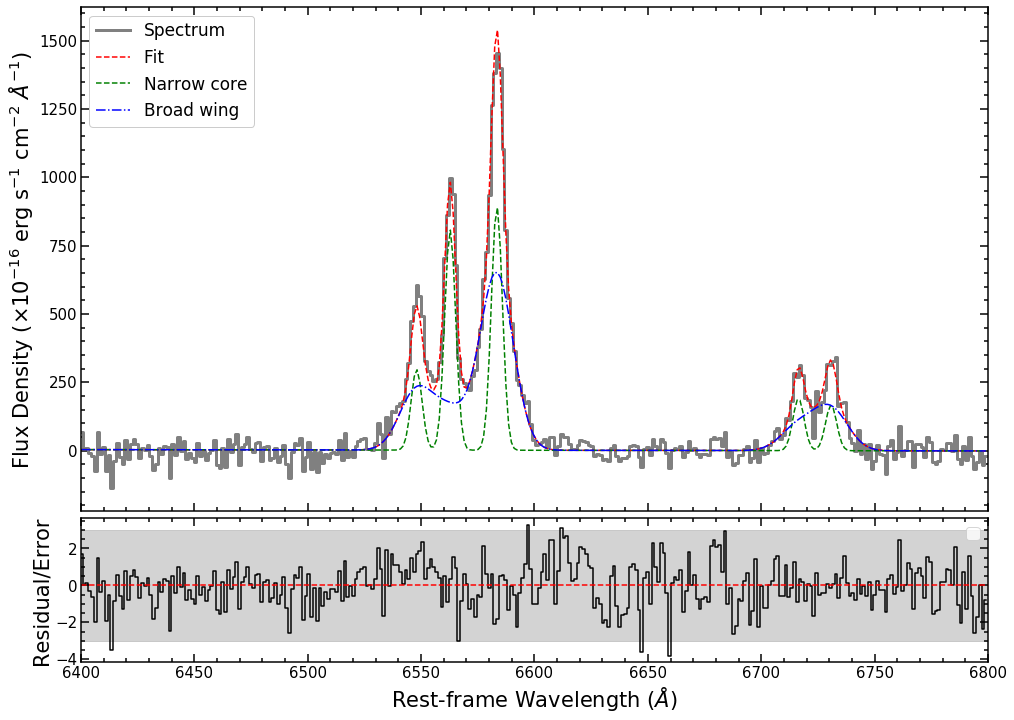

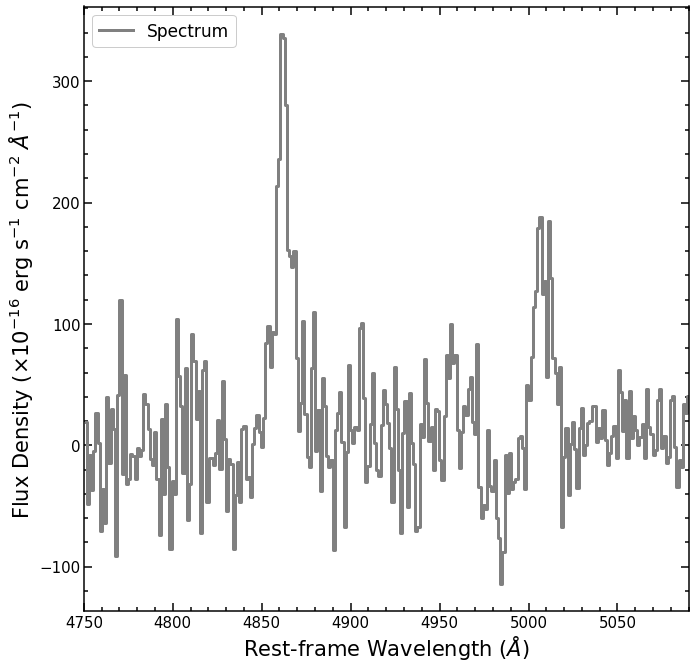

In [6]:
z = {"3C264":0.02172}

objs = z.keys()


p_init= {'3C264':[300,100,8,8,6516.0,100,30,10,1,1,6416.0,200.0,-0.001,2.0]
}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj]) 


In [ ]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z):
    k = 1+z
    select = (wo_wave>6400*k) & (wo_wave<6800*k)
    popt_full_fit,pcov_full_fit = leastsq(Type2_gauss_coupled,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 10
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(Type2_gauss_coupled,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Ha_error,amp_NII6583_error,amp_SII6716_error,amp_SII6731_error,vel_Ha_error,vel_sigma_Ha_error,amp_Ha_br_error,amp_NII6583_br_error,amp_SII6716_br_error,amp_SII6731_br_error,vel_Ha_br_error,vel_sigma_Ha_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 